# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
pltfrom skimage.transform import resize
from skimage.morphology import label

from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.layers.core import Lambda
# Dropout, 
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

model_checkpoint_file = 'model-dsbowl2018-batchnorm.h5'
submission_file = 'sub-dsbowl2018_batchNorm.csv'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# For reproducibilitiy - does this work??
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [05:27<00:00,  2.04it/s]


Getting and resizing test images ... 


100%|██████████| 65/65 [00:02<00:00, 29.32it/s]


Done!


Let's see if things look all right by drawing some random images and their associated masks.

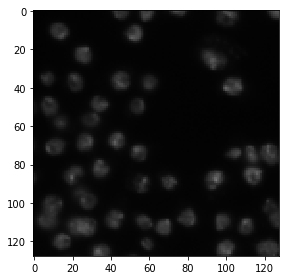

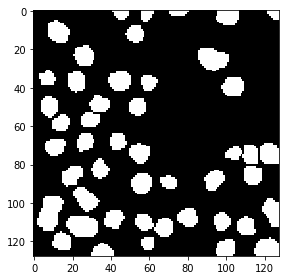

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

smooth = 1
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

# I should make the layers into functions like this - https://www.kaggle.com/ecobill/u-nets-with-keras

## How do I keep track of the size of my image???

# Parameters
l2_reg = 0.0001  # adding l2 regularization makes loss explode on initial step for some reason
dil_rate=(1,1)
dil_rate_up=(1,1)
#dil_rate_center=(2,2)
filter_size=(3,3)
stride_size=(1,1) # stride > 1 not supported with dilation > 1

### GOOOOOING DOOOOOWNNNN
 
d1 = Conv2D(20, filter_size, padding='same', kernel_initializer='he_normal', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (s)
d1 = BatchNormalization() (d1) 
d1 = Activation('elu') (d1) 
d1 = Conv2D(20, filter_size, padding='same', kernel_initializer='he_normal', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (d1)
d1 = BatchNormalization() (d1) 
d1 = Activation('elu') (d1) 
p1 = MaxPooling2D((2, 2),strides=(2, 2)) (d1)

d2 = Conv2D(40, filter_size,strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (p1)
d2 = BatchNormalization() (d2) 
d2 = Activation('elu') (d2)
d2 = Conv2D(40, filter_size,strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (d2)
d2 = BatchNormalization() (d2) 
d2 = Activation('elu') (d2)
p2 = MaxPooling2D((2, 2),strides=(2, 2)) (d2)

d3 = Conv2D(80, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (p2)
d3 = BatchNormalization() (d3) 
d3 = Activation('elu') (d3)
d3 = Conv2D(80, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (d3)
d3 = BatchNormalization() (d3) 
d3 = Activation('elu') (d3)
p3 = MaxPooling2D((2, 2),strides=(2, 2)) (d3)

d4 = Conv2D(160, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (p3)
d4 = BatchNormalization() (d4) 
d4 = Activation('elu') (d4)
d4 = Conv2D(160, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate, kernel_regularizer=regularizers.l2(l2_reg)) (d4)
d4 = BatchNormalization() (d4) 
d4 = Activation('elu') (d4)
p4 = MaxPooling2D((2, 2),strides=(2, 2)) (d4)

### CENTER 

c = Conv2D(20, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = (1,1), kernel_regularizer=regularizers.l2(l2_reg)) (p4)
c = BatchNormalization() (c) 
c = Activation('elu') (c)
c = Conv2D(20, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = (2,2), kernel_regularizer=regularizers.l2(l2_reg)) (c)
c = BatchNormalization() (c) 
c = Activation('elu') (c)
#c = Conv2D(20, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = (4,4), kernel_regularizer=regularizers.l2(l2_reg)) (c)
#c = BatchNormalization() (c) 
#c = Activation('elu') (c)
#c = Conv2D(20, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = (8,8), kernel_regularizer=regularizers.l2(l2_reg)) (c)
#c = BatchNormalization() (c) 
#c = Activation('relu') (c)

### Now we GOOOOO UPPPPP

u1 = UpSampling2D((2, 2))(c)
u1 = concatenate([u1, d4],axis=3)
u1 = Conv2D(160, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u1)
u1 = BatchNormalization() (u1) 
u1 = Activation('elu') (u1)
u1 = Conv2D(160, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u1)
u1 = BatchNormalization() (u1) 
u1 = Activation('elu') (u1)

u2 = UpSampling2D((2, 2))(u1)
u2 = concatenate([u2, d3],axis=3)
u2 = Conv2D(80, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u2)
u2 = BatchNormalization() (u2) 
u2 = Activation('elu') (u2)
u2 = Conv2D(80, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u2)
u2 = BatchNormalization() (u2) 
u2 = Activation('elu') (u2)

u3 = UpSampling2D((2, 2))(u2)
u3 = concatenate([u3, d2],axis=3)
u3 = Conv2D(40, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u3)
u3 = BatchNormalization() (u3) 
u3 = Activation('elu') (u3)
u3 = Conv2D(40, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u3)
u3 = BatchNormalization() (u3) 
u3 = Activation('elu') (u3)

u4 = UpSampling2D((2, 2))(u3)
u4 = concatenate([u4, d1],axis=3)
u4 = Conv2D(20, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u4)
u4 = BatchNormalization() (u4) 
u4 = Activation('elu') (u4)
u4 = Conv2D(20, filter_size, strides=stride_size, kernel_initializer='he_normal', padding='same', dilation_rate = dil_rate_up, kernel_regularizer=regularizers.l2(l2_reg)) (u4)
u4 = BatchNormalization() (u4) 
u4 = Activation('elu') (u4)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (u4)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam (lr=0.001), loss='binary_crossentropy', metrics=[mean_iou, dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 20) 560         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 20) 80          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [7]:
# Fit model

# Implement learning rate decay https://keras.io/callbacks/#learningratescheduler 

earlystopper = EarlyStopping(patience=4, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5,
                           patience=2,
                           verbose=1,
                           mode='auto') 
# verbose=2 => one line per epoch, 1 = progress bar
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=15, epochs=30, verbose=1 , 
                    callbacks=[earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/30
600/603 [============================>.] - ETA: 11:33 - loss: 1.0039 - mean_iou: 0.0000e+00 - dice_coef: 0.190 - ETA: 9:40 - loss: 0.9779 - mean_iou: 0.2011 - dice_coef: 0.2800    - ETA: 8:43 - loss: 0.9370 - mean_iou: 0.2707 - dice_coef: 0.28 - ETA: 8:07 - loss: 0.9181 - mean_iou: 0.3138 - dice_coef: 0.27 - ETA: 7:38 - loss: 0.8923 - mean_iou: 0.3444 - dice_coef: 0.28 - ETA: 7:17 - loss: 0.8789 - mean_iou: 0.3691 - dice_coef: 0.29 - ETA: 6:56 - loss: 0.8633 - mean_iou: 0.3882 - dice_coef: 0.30 - ETA: 6:41 - loss: 0.8469 - mean_iou: 0.4048 - dice_coef: 0.31 - ETA: 6:24 - loss: 0.8308 - mean_iou: 0.4197 - dice_coef: 0.32 - ETA: 6:09 - loss: 0.8168 - mean_iou: 0.4333 - dice_coef: 0.33 - ETA: 5:55 - loss: 0.8017 - mean_iou: 0.4456 - dice_coef: 0.34 - ETA: 5:42 - loss: 0.7973 - mean_iou: 0.4571 - dice_coef: 0.35 - ETA: 5:29 - loss: 0.7874 - mean_iou: 0.4669 - dice_coef: 0.36 - ETA: 5:16 - loss: 0.7759 - mean_iou: 0.4760 - dice_coef: 0

600/603 [============================>.] - ETA: 6:54 - loss: 0.3153 - mean_iou: 0.7859 - dice_coef: 0.71 - ETA: 6:54 - loss: 0.3124 - mean_iou: 0.7861 - dice_coef: 0.69 - ETA: 6:48 - loss: 0.3161 - mean_iou: 0.7863 - dice_coef: 0.70 - ETA: 6:35 - loss: 0.3083 - mean_iou: 0.7864 - dice_coef: 0.71 - ETA: 6:26 - loss: 0.3019 - mean_iou: 0.7865 - dice_coef: 0.71 - ETA: 6:16 - loss: 0.3036 - mean_iou: 0.7867 - dice_coef: 0.72 - ETA: 6:04 - loss: 0.3048 - mean_iou: 0.7868 - dice_coef: 0.72 - ETA: 5:52 - loss: 0.3009 - mean_iou: 0.7869 - dice_coef: 0.72 - ETA: 5:43 - loss: 0.2983 - mean_iou: 0.7871 - dice_coef: 0.72 - ETA: 5:32 - loss: 0.3014 - mean_iou: 0.7872 - dice_coef: 0.72 - ETA: 5:21 - loss: 0.2975 - mean_iou: 0.7874 - dice_coef: 0.72 - ETA: 5:10 - loss: 0.2968 - mean_iou: 0.7876 - dice_coef: 0.72 - ETA: 4:59 - loss: 0.2938 - mean_iou: 0.7877 - dice_coef: 0.73 - ETA: 4:49 - loss: 0.2974 - mean_iou: 0.7879 - dice_coef: 0.72 - ETA: 4:38 - loss: 0.2955 - mean_iou: 0.7880 - dice_coef: 0.72

600/603 [============================>.] - ETA: 7:13 - loss: 0.2194 - mean_iou: 0.8200 - dice_coef: 0.82 - ETA: 7:00 - loss: 0.2317 - mean_iou: 0.8200 - dice_coef: 0.79 - ETA: 6:47 - loss: 0.3556 - mean_iou: 0.8200 - dice_coef: 0.72 - ETA: 6:33 - loss: 0.3309 - mean_iou: 0.8199 - dice_coef: 0.72 - ETA: 6:24 - loss: 0.3315 - mean_iou: 0.8198 - dice_coef: 0.69 - ETA: 6:14 - loss: 0.3169 - mean_iou: 0.8197 - dice_coef: 0.69 - ETA: 6:03 - loss: 0.3048 - mean_iou: 0.8196 - dice_coef: 0.70 - ETA: 5:56 - loss: 0.2933 - mean_iou: 0.8196 - dice_coef: 0.71 - ETA: 5:45 - loss: 0.3042 - mean_iou: 0.8196 - dice_coef: 0.71 - ETA: 5:33 - loss: 0.2991 - mean_iou: 0.8195 - dice_coef: 0.71 - ETA: 5:22 - loss: 0.2902 - mean_iou: 0.8195 - dice_coef: 0.72 - ETA: 5:12 - loss: 0.2824 - mean_iou: 0.8195 - dice_coef: 0.73 - ETA: 5:01 - loss: 0.2787 - mean_iou: 0.8195 - dice_coef: 0.73 - ETA: 4:50 - loss: 0.2753 - mean_iou: 0.8195 - dice_coef: 0.73 - ETA: 4:40 - loss: 0.2737 - mean_iou: 0.8195 - dice_coef: 0.73

600/603 [============================>.] - ETA: 8:11 - loss: 0.1798 - mean_iou: 0.8288 - dice_coef: 0.80 - ETA: 7:47 - loss: 0.1773 - mean_iou: 0.8288 - dice_coef: 0.82 - ETA: 7:21 - loss: 0.1819 - mean_iou: 0.8289 - dice_coef: 0.80 - ETA: 7:04 - loss: 0.1781 - mean_iou: 0.8289 - dice_coef: 0.81 - ETA: 6:53 - loss: 0.1818 - mean_iou: 0.8289 - dice_coef: 0.81 - ETA: 6:46 - loss: 0.1767 - mean_iou: 0.8289 - dice_coef: 0.82 - ETA: 6:38 - loss: 0.1770 - mean_iou: 0.8289 - dice_coef: 0.82 - ETA: 6:29 - loss: 0.1737 - mean_iou: 0.8289 - dice_coef: 0.82 - ETA: 6:20 - loss: 0.1717 - mean_iou: 0.8289 - dice_coef: 0.82 - ETA: 6:10 - loss: 0.1689 - mean_iou: 0.8290 - dice_coef: 0.82 - ETA: 6:00 - loss: 0.1720 - mean_iou: 0.8290 - dice_coef: 0.82 - ETA: 5:47 - loss: 0.1787 - mean_iou: 0.8290 - dice_coef: 0.81 - ETA: 5:32 - loss: 0.1782 - mean_iou: 0.8291 - dice_coef: 0.81 - ETA: 5:17 - loss: 0.1767 - mean_iou: 0.8291 - dice_coef: 0.81 - ETA: 5:04 - loss: 0.1766 - mean_iou: 0.8291 - dice_coef: 0.82

600/603 [============================>.] - ETA: 8:20 - loss: 0.1292 - mean_iou: 0.8368 - dice_coef: 0.84 - ETA: 8:03 - loss: 0.1441 - mean_iou: 0.8368 - dice_coef: 0.83 - ETA: 7:48 - loss: 0.1447 - mean_iou: 0.8368 - dice_coef: 0.82 - ETA: 7:32 - loss: 0.1488 - mean_iou: 0.8368 - dice_coef: 0.83 - ETA: 7:18 - loss: 0.1408 - mean_iou: 0.8368 - dice_coef: 0.83 - ETA: 7:13 - loss: 0.1404 - mean_iou: 0.8368 - dice_coef: 0.84 - ETA: 6:57 - loss: 0.1389 - mean_iou: 0.8369 - dice_coef: 0.84 - ETA: 6:45 - loss: 0.1378 - mean_iou: 0.8369 - dice_coef: 0.84 - ETA: 6:32 - loss: 0.1364 - mean_iou: 0.8369 - dice_coef: 0.84 - ETA: 6:19 - loss: 0.1372 - mean_iou: 0.8369 - dice_coef: 0.84 - ETA: 6:06 - loss: 0.1364 - mean_iou: 0.8369 - dice_coef: 0.84 - ETA: 5:53 - loss: 0.1357 - mean_iou: 0.8370 - dice_coef: 0.84 - ETA: 5:44 - loss: 0.1355 - mean_iou: 0.8370 - dice_coef: 0.84 - ETA: 5:30 - loss: 0.1358 - mean_iou: 0.8370 - dice_coef: 0.85 - ETA: 5:16 - loss: 0.1354 - mean_iou: 0.8371 - dice_coef: 0.85

600/603 [============================>.] - ETA: 8:26 - loss: 0.1130 - mean_iou: 0.8430 - dice_coef: 0.85 - ETA: 8:13 - loss: 0.1105 - mean_iou: 0.8430 - dice_coef: 0.83 - ETA: 7:48 - loss: 0.1199 - mean_iou: 0.8431 - dice_coef: 0.83 - ETA: 7:28 - loss: 0.1277 - mean_iou: 0.8431 - dice_coef: 0.83 - ETA: 7:10 - loss: 0.1259 - mean_iou: 0.8431 - dice_coef: 0.83 - ETA: 6:52 - loss: 0.1270 - mean_iou: 0.8431 - dice_coef: 0.83 - ETA: 6:37 - loss: 0.1347 - mean_iou: 0.8431 - dice_coef: 0.83 - ETA: 6:29 - loss: 0.1385 - mean_iou: 0.8431 - dice_coef: 0.83 - ETA: 6:19 - loss: 0.1367 - mean_iou: 0.8431 - dice_coef: 0.84 - ETA: 6:10 - loss: 0.1360 - mean_iou: 0.8431 - dice_coef: 0.84 - ETA: 6:02 - loss: 0.1350 - mean_iou: 0.8431 - dice_coef: 0.84 - ETA: 5:53 - loss: 0.1345 - mean_iou: 0.8432 - dice_coef: 0.84 - ETA: 5:41 - loss: 0.1335 - mean_iou: 0.8432 - dice_coef: 0.84 - ETA: 5:29 - loss: 0.1316 - mean_iou: 0.8432 - dice_coef: 0.84 - ETA: 5:15 - loss: 0.1303 - mean_iou: 0.8432 - dice_coef: 0.84

KeyboardInterrupt: 


# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [8]:
# Predict on train, val and test
model = load_model(model_checkpoint_file, custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions  -  should we optimize this threshold???
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 19s 287ms/step


In [ ]:
# Perform a sanity check on some random training samples

ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

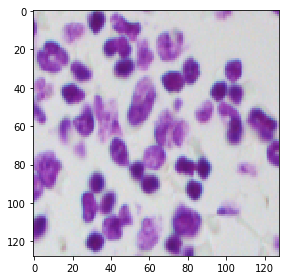

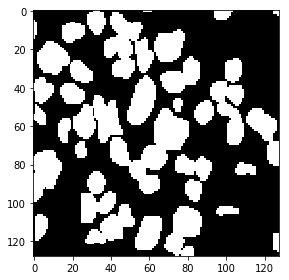

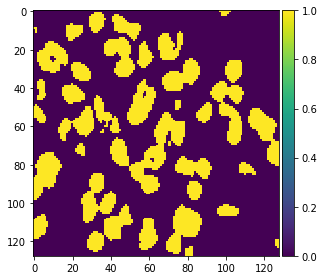

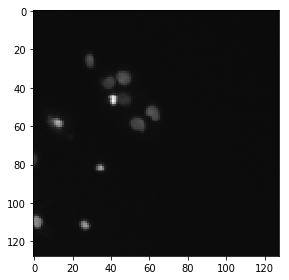

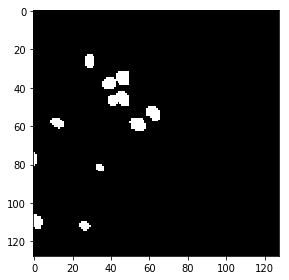

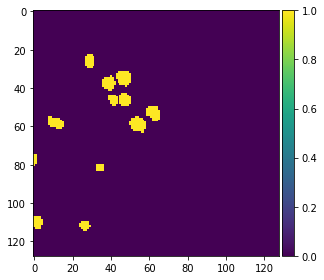

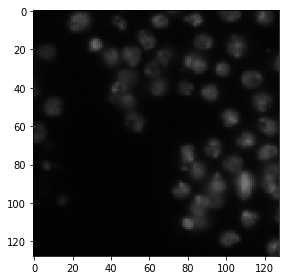

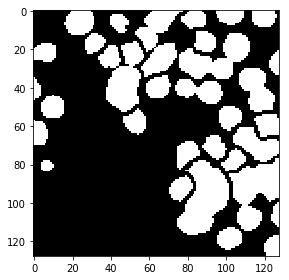

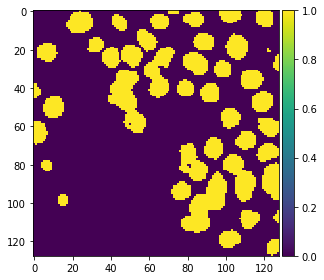

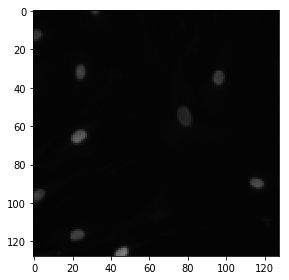

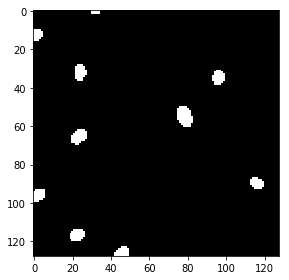

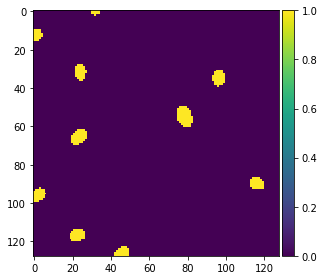

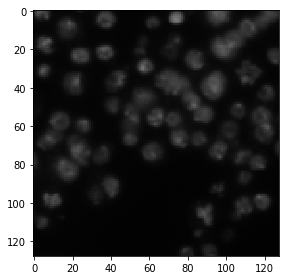

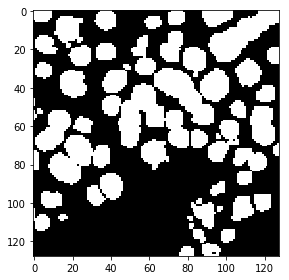

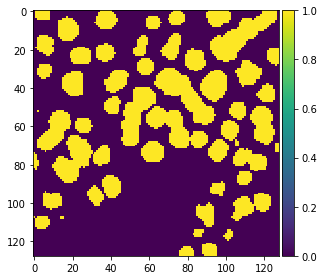

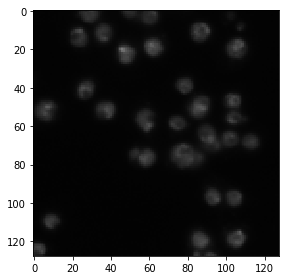

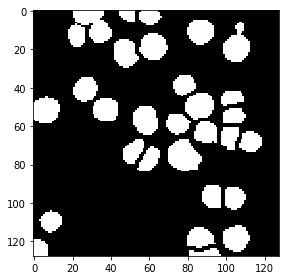

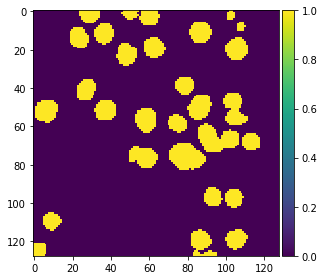

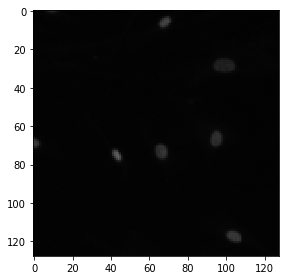

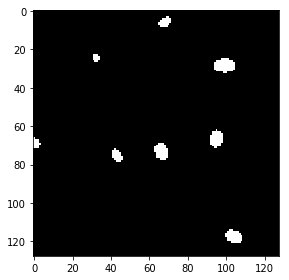

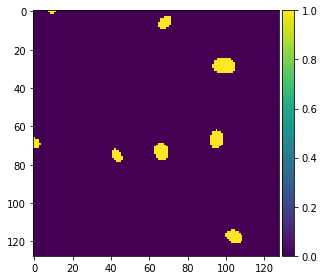

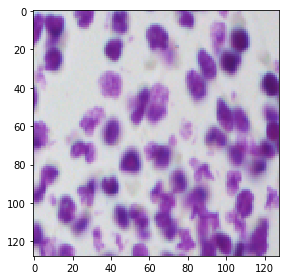

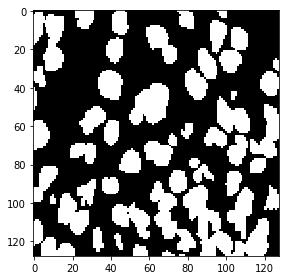

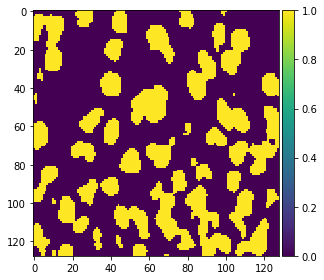

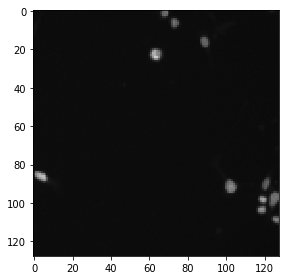

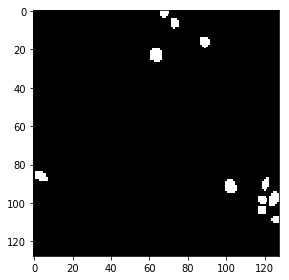

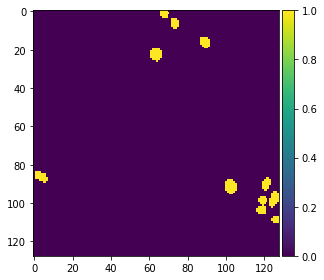

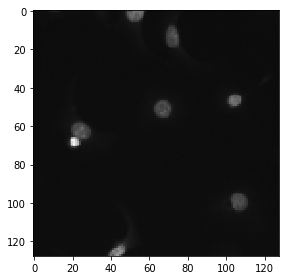

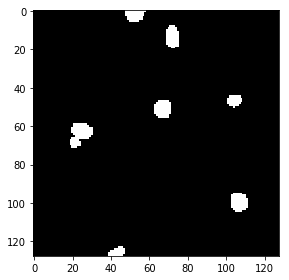

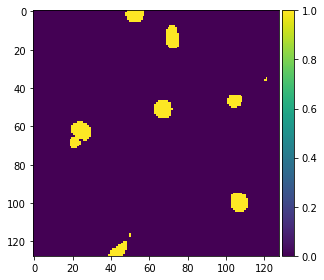

In [9]:
# Perform a sanity check on some random validation samples

for i in range(10):
    ix = random.randint(0, len(preds_val_t))
    imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    plt.show()
    imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(submission_file, index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB